In [1]:
!pip uninstall timm --y
!pip -q install --pre timm
!pip -q install torchinfo

Found existing installation: timm 0.6.13
Uninstalling timm-0.6.13:
  Successfully uninstalled timm-0.6.13


In [2]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 

from PIL import Image
import cv2
import os 
import shutil

import random

import timm
import timm.optim
import timm.scheduler
from timm.data import ImageDataset, create_dataset, create_loader
from timm.data.transforms_factory import create_transform

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchinfo import summary

from fastai.vision.all import *
from fastai.vision.data import ImageDataLoaders



from sklearn.model_selection import train_test_split

**Plot distribution**

0 : 943
1 : 940
10 : 946
11 : 921
12 : 919
13 : 935
14 : 881
15 : 929
16 : 935
17 : 928
18 : 921
19 : 958
2 : 855
20 : 943
21 : 883
22 : 931
23 : 931
24 : 928
25 : 941
26 : 950
27 : 919
28 : 945
29 : 908
3 : 926
30 : 989
31 : 985
32 : 985
33 : 982
34 : 986
35 : 991
36 : 982
37 : 937
38 : 990
39 : 995
4 : 910
40 : 994
41 : 974
42 : 986
43 : 949
44 : 940
45 : 995
46 : 941
47 : 905
48 : 922
49 : 908
5 : 934
50 : 918
51 : 909
52 : 897
53 : 904
54 : 883
55 : 878
56 : 898
57 : 905
58 : 907
59 : 897
6 : 946
60 : 884
61 : 903
62 : 790
63 : 921
64 : 941
65 : 878
66 : 933
67 : 912
7 : 937
8 : 929
9 : 961


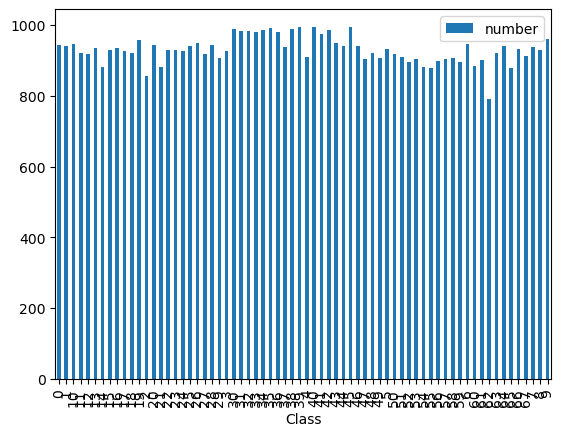

In [3]:
path_folder = '/kaggle/input/thai-handwritten-characters-recognition/train/train/'
category_class = os.listdir(path_folder)
category_class.sort()

num_class = [len(os.listdir(path_folder+class_)) for class_ in category_class]
num_class

df_plot = pd.DataFrame({'Class':category_class, 'number':num_class})
ax = df_plot.plot.bar(x='Class', y='number')

for class_, num_ in zip(category_class,num_class) :
    print( class_,':', num_)

In [4]:
img=Image.open('/kaggle/input/thai-handwritten-characters-recognition/train/train/0/Set2_F1_P-0001_23.jpg')
img.size

(151, 146)

In [5]:
avail_pretrained_models = timm.list_models('*clip*',pretrained=True)
len(avail_pretrained_models), avail_pretrained_models[:]

(53,
 ['convnext_base.clip_laion2b',
  'convnext_base.clip_laion2b_augreg',
  'convnext_base.clip_laion2b_augreg_ft_in1k',
  'convnext_base.clip_laiona',
  'convnext_base.clip_laiona_320',
  'convnext_base.clip_laiona_augreg_320',
  'convnext_base.clip_laiona_augreg_ft_in1k_384',
  'convnext_large_mlp.clip_laion2b_augreg',
  'convnext_large_mlp.clip_laion2b_augreg_ft_in1k',
  'convnext_large_mlp.clip_laion2b_augreg_ft_in1k_384',
  'convnext_large_mlp.clip_laion2b_ft_320',
  'convnext_large_mlp.clip_laion2b_ft_soup_320',
  'convnext_xxlarge.clip_laion2b_rewind',
  'convnext_xxlarge.clip_laion2b_soup',
  'eva_giant_patch14_224.clip_ft_in1k',
  'eva_giant_patch14_336.clip_ft_in1k',
  'vit_base_patch16_clip_224.laion2b_ft_in1k',
  'vit_base_patch16_clip_224.laion2b_ft_in12k',
  'vit_base_patch16_clip_224.laion2b_ft_in12k_in1k',
  'vit_base_patch16_clip_224.openai',
  'vit_base_patch16_clip_224.openai_ft_in1k',
  'vit_base_patch16_clip_224.openai_ft_in12k',
  'vit_base_patch16_clip_224.open

In [6]:
image_size = 224
batch = 32

In [7]:
dls = ImageDataLoaders.from_folder('/kaggle/input/thai-handwritten-characters-recognition/train/train',
                                    train ='train',
                                    valid_pct=0.2,
                                    bs = batch ,
                                    img_cls=PILImageBW,
                                    shuffle_train = True,
                                    item_tfms=[ToTensor(),Resize(image_size)] ,
                                    batch_tfms=[*aug_transforms(do_flip=False,
                                                                flip_vert=False,
                                                                max_rotate=20,
                                                                p_affine=0.8,
                                                                max_warp=0.2),
                                                Normalize.from_stats(*imagenet_stats),
                                               ],
                                    seed = 123,
                                    )

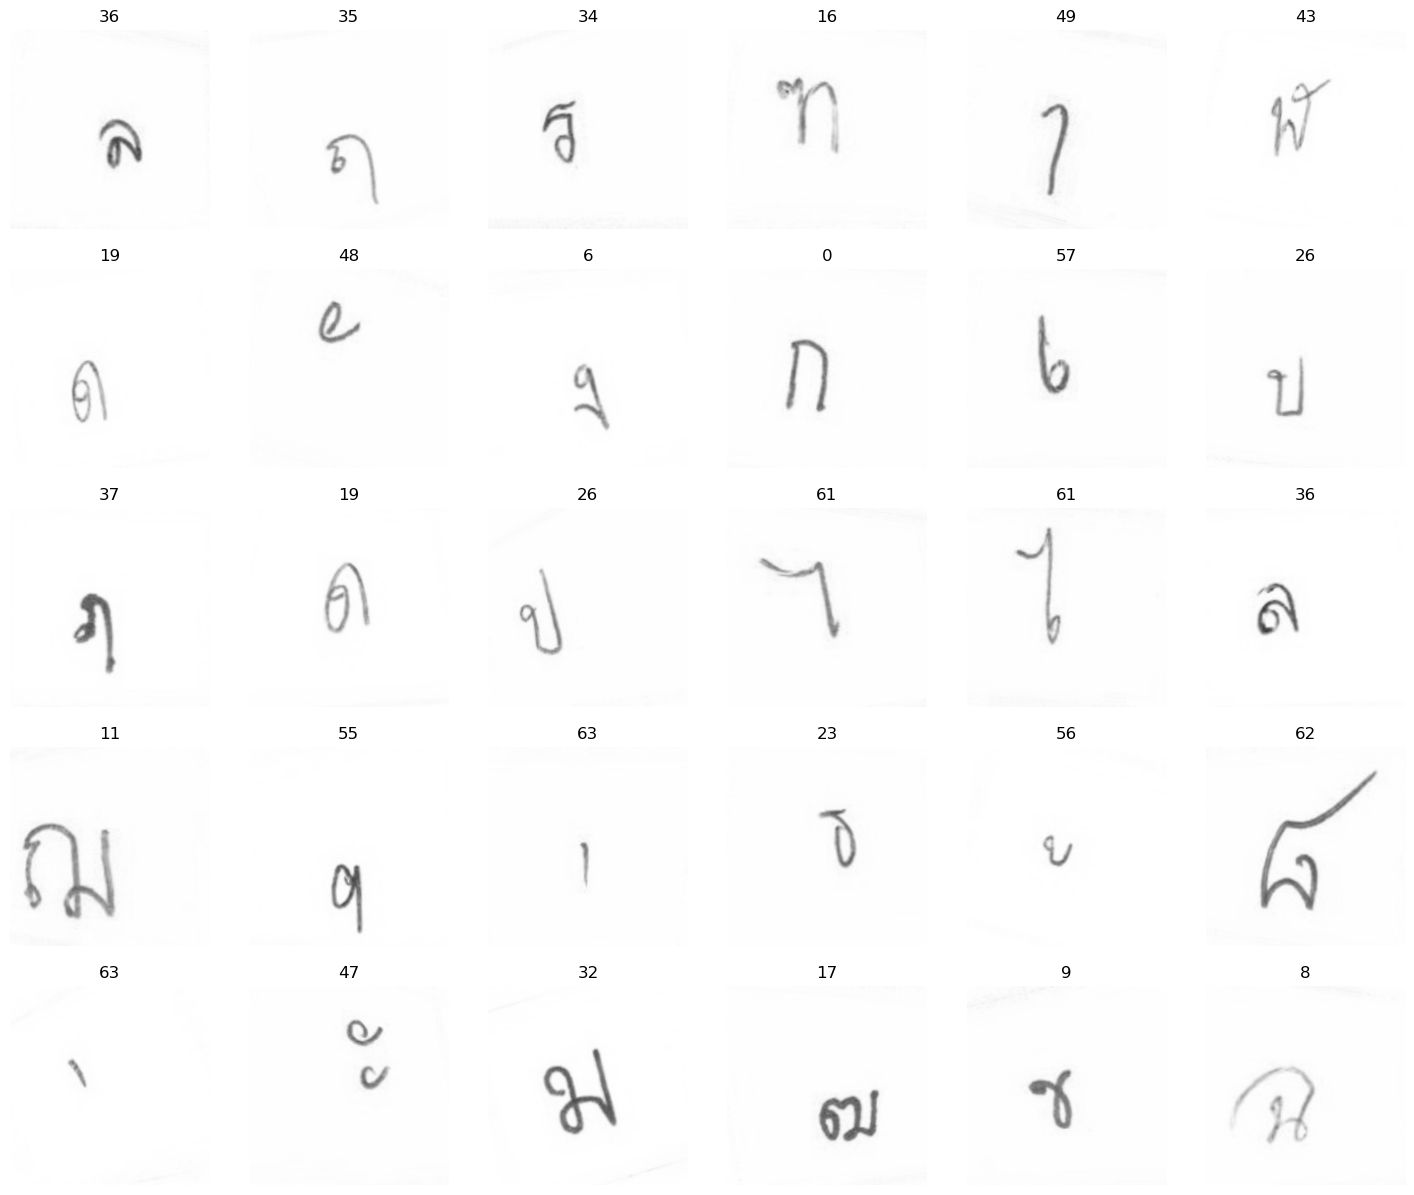

In [8]:
dls.train.show_batch(max_n=30)

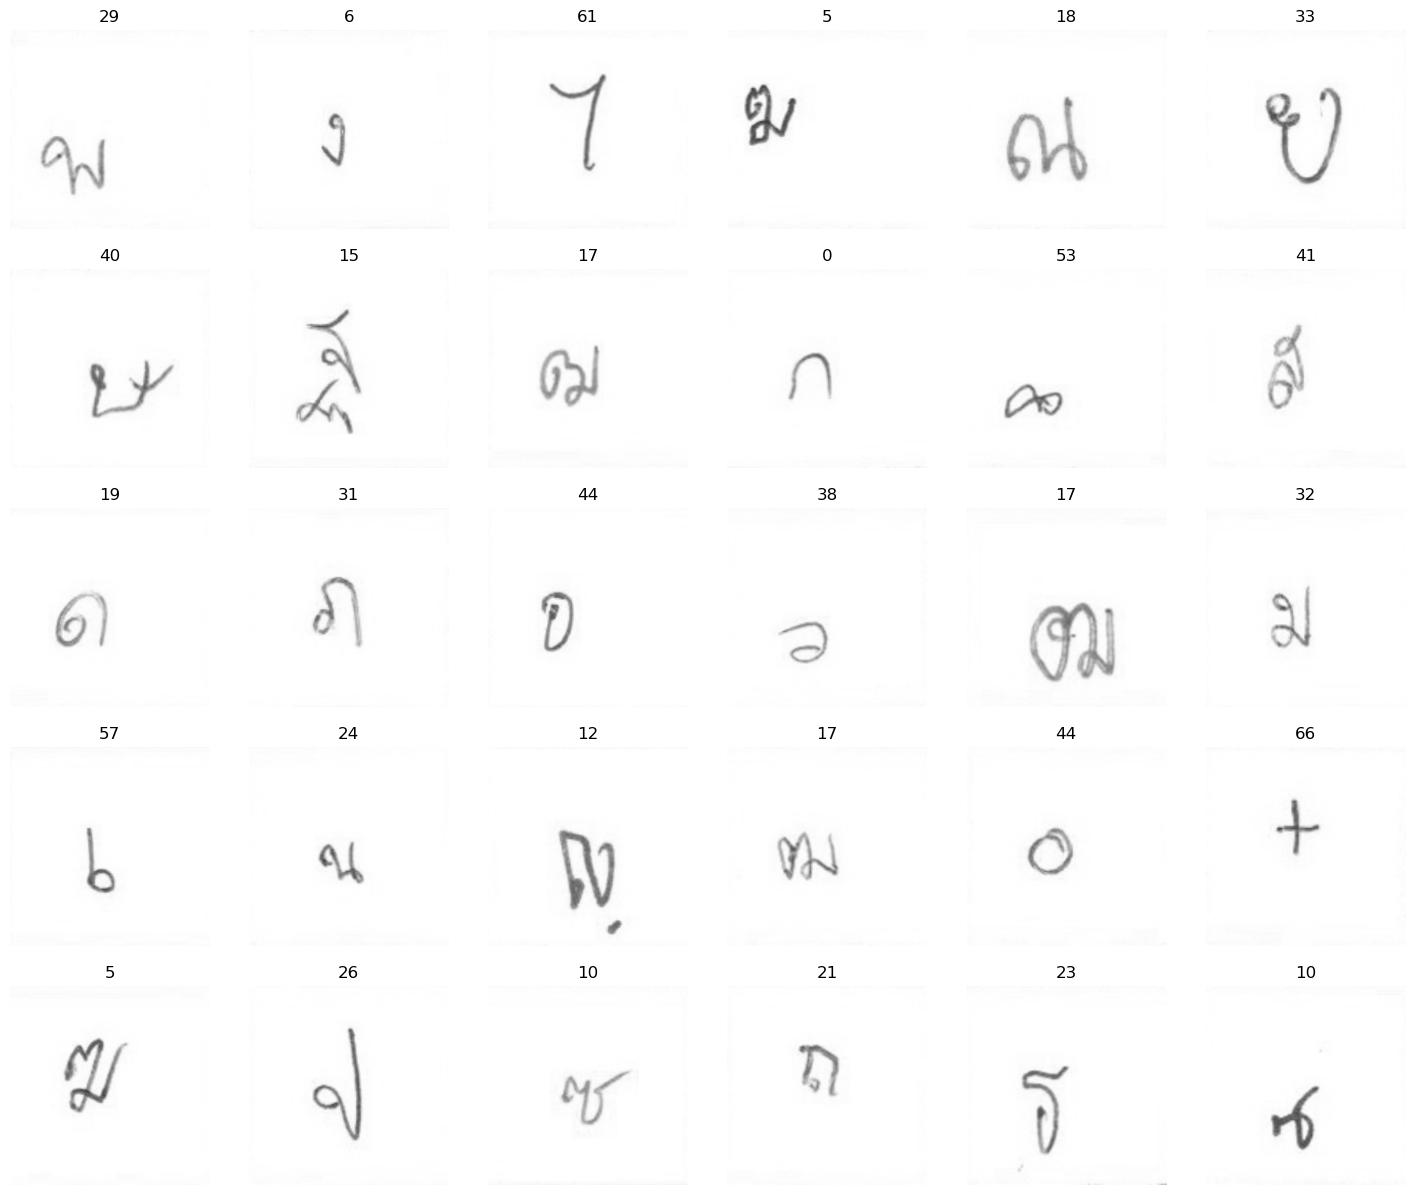

In [9]:
dls.valid.show_batch(max_n=30)

In [10]:
dls.vocab

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '7', '8', '9']

In [11]:
# loss_func2 = CrossEntropyLossFlat(weight=class_weights)
save_cb = SaveModelCallback(monitor='valid_loss',at_end=False,every_epoch=True)
early_stop_cb = EarlyStoppingCallback(monitor='valid_loss',min_delta=0.001 ,patience=10)

# Create a list of callbacks
callbacks = [save_cb,early_stop_cb]   #

In [12]:
from fastai.metrics import accuracy, F1Score

model_name = "vit_large_patch14_clip_224.laion2b_ft_in12k_in1k"

epoch = 20
learn = vision_learner(dls, model_name,pretrained=True,
                    #    loss_func=CrossEntropyLoss(),
#                        opt_func=ranger ,
                       path='/kaggle/working/',
                       cbs=[ShowGraphCallback()] ,
                       metrics=[accuracy]).to_fp16()  # metrics=[accuracy]
                     #    #,WandbCallback()     force_download=True, 
learn.model = torch.nn.DataParallel(learn.model)

epoch,train_loss,valid_loss,accuracy,time
0,1.434575,0.742101,0.780497,30:08
1,0.589715,0.342045,0.896407,30:04
2,0.423041,0.245926,0.927043,30:06


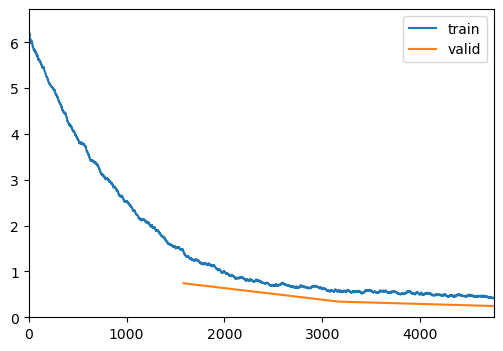

epoch,train_loss,valid_loss,accuracy,time
0,0.266136,0.171995,0.950415,36:18
1,0.237884,0.187676,0.944887,36:19
2,0.241610,0.165829,0.952783,36:17
3,0.173112,0.150696,0.956652,36:16
4,0.169059,0.150466,0.957837,36:11
5,0.145109,0.130139,0.964943,36:15
6,0.098907,0.122748,0.967075,36:15
7,0.065069,0.124341,0.967943,36:14
8,0.057064,0.122136,0.969285,36:15
9,0.064289,0.120772,0.968812,36:10


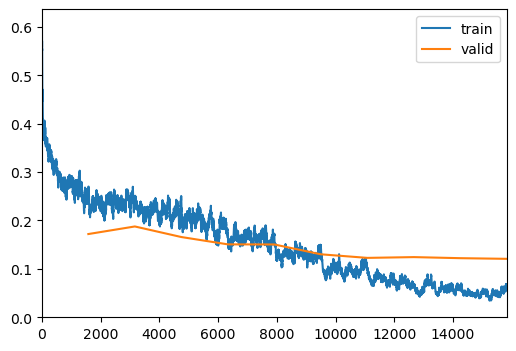

In [13]:
learn.fine_tune(10,freeze_epochs=3,cbs=callbacks)

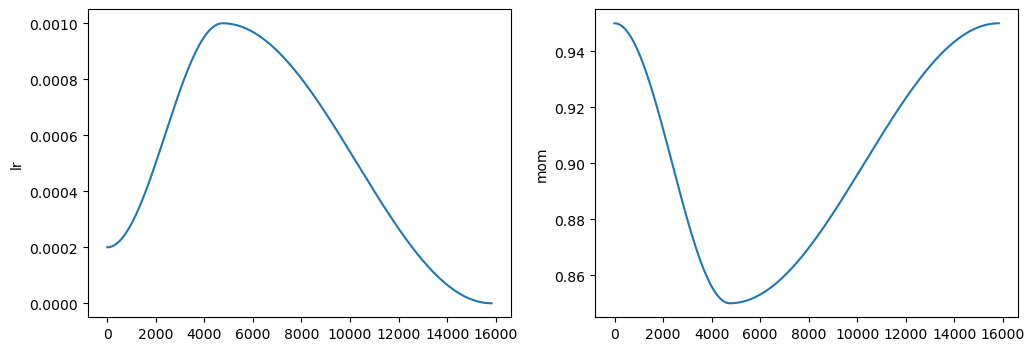

In [14]:
learn.recorder.plot_sched()

In [15]:
learn.validate()

(#2) [0.12077154964208603,0.9688116908073425]

In [16]:
# learn.load("model_10")
# learn.validate()

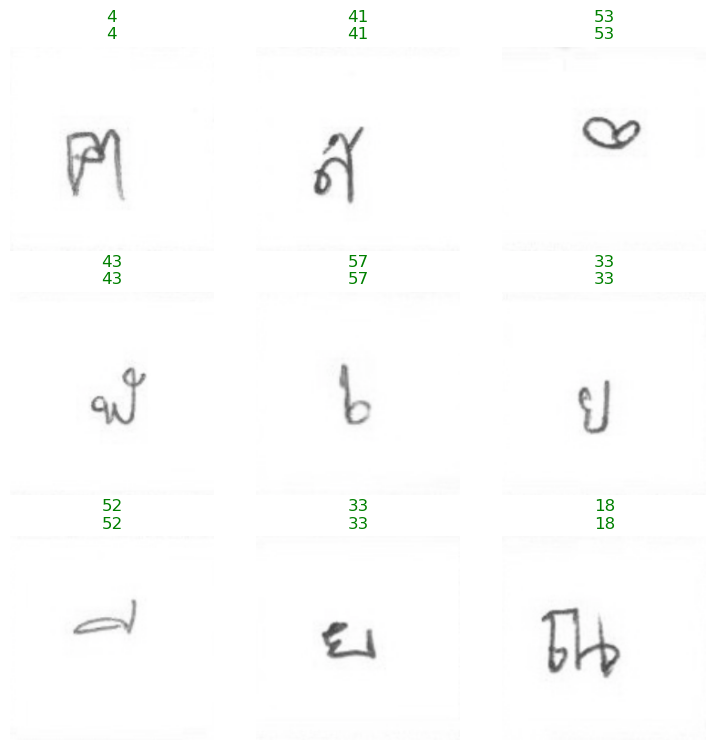

In [17]:
learn.show_results()

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       199
           1       0.74      0.85      0.79       175
          10       0.99      0.96      0.98       200
          11       0.98      0.99      0.99       170
          12       0.99      1.00      0.99       178
          13       0.96      0.95      0.96       157
          14       0.97      0.97      0.97       179
          15       1.00      1.00      1.00       204
          16       1.00      0.99      0.99       176
          17       0.99      0.99      0.99       178
          18       0.98      0.99      0.99       187
          19       0.95      0.95      0.95       192
           2       0.98      1.00      0.99       173
          20       0.98      0.96      0.97       194
          21       0.90      0.90      0.90       169
          22       0.98      0.99      0.98       205
          23       0.96      0.97      0.97       188
          24       0.99    

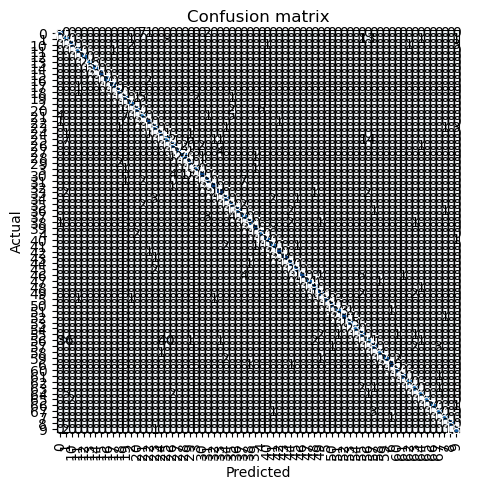

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.print_classification_report()

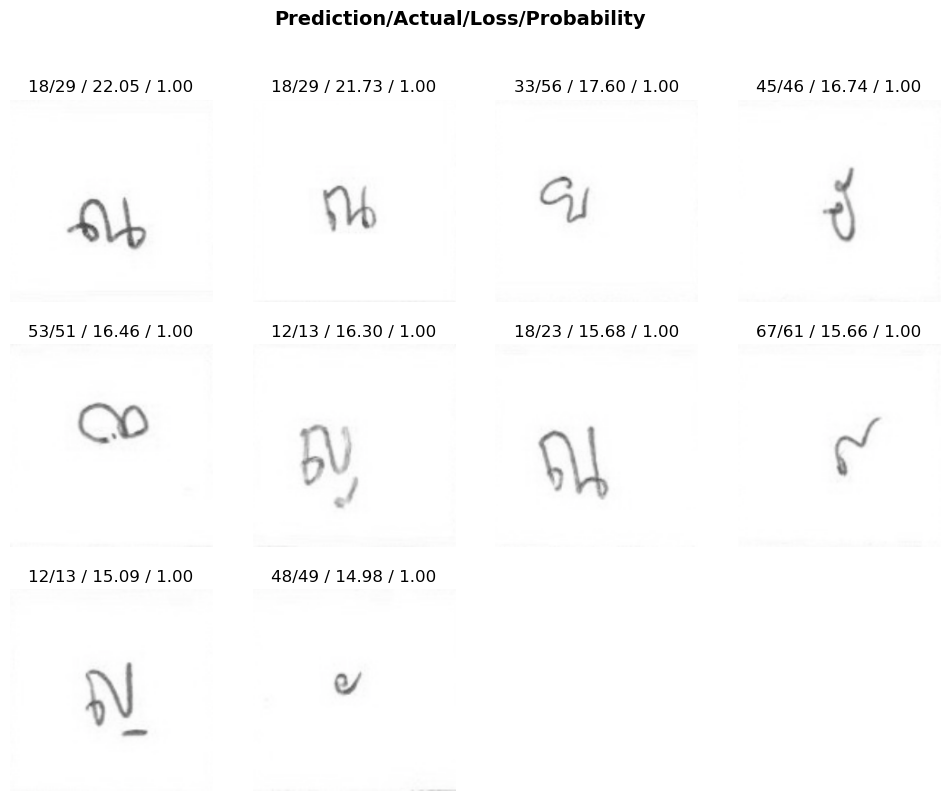

In [19]:
interp.plot_top_losses(10)


In [20]:
df_submission = pd.read_csv('/kaggle/input/thai-handwritten-characters-recognition/submission.csv')
df_submission

,filename,class
0,0.jpg,28.0
1,1.jpg,8.0
2,2.jpg,9.0
3,3.jpg,NaN
4,4.jpg,NaN
...,...,...
13594,13594.jpg,NaN
13595,13595.jpg,NaN
13596,13596.jpg,NaN
13597,13597.jpg,NaN


In [21]:
df_test=df_submission.copy()
df_test['filename']='/kaggle/input/thai-handwritten-characters-recognition/test/test/'+df_test['filename']
df_test

,filename,class
0,/kaggle/input/thai-handwritten-characters-recognition/test/test/0.jpg,28.0
1,/kaggle/input/thai-handwritten-characters-recognition/test/test/1.jpg,8.0
2,/kaggle/input/thai-handwritten-characters-recognition/test/test/2.jpg,9.0
3,/kaggle/input/thai-handwritten-characters-recognition/test/test/3.jpg,NaN
4,/kaggle/input/thai-handwritten-characters-recognition/test/test/4.jpg,NaN
...,...,...
13594,/kaggle/input/thai-handwritten-characters-recognition/test/test/13594.jpg,NaN
13595,/kaggle/input/thai-handwritten-characters-recognition/test/test/13595.jpg,NaN
13596,/kaggle/input/thai-handwritten-characters-recognition/test/test/13596.jpg,NaN
13597,/kaggle/input/thai-handwritten-characters-recognition/test/test/13597.jpg,NaN


In [22]:
learn.predict(df_test['filename'][2])

('9',
 tensor(67),
 tensor([9.3274e-09, 1.5653e-07, 6.9765e-05, 2.3124e-10, 1.5406e-09, 2.3263e-09,
         8.4089e-10, 3.2424e-09, 4.7170e-10, 4.1709e-10, 1.0757e-08, 1.4137e-09,
         1.0005e-09, 6.8709e-09, 1.2872e-09, 3.8516e-07, 3.0212e-08, 5.0968e-08,
         5.4994e-09, 4.3045e-08, 1.2770e-10, 3.1238e-10, 1.1314e-10, 4.0510e-09,
         3.4684e-09, 5.7232e-10, 1.0989e-09, 5.5906e-10, 3.2935e-09, 4.8953e-10,
         2.2453e-11, 6.6650e-10, 8.3598e-10, 8.3135e-08, 1.6953e-09, 1.8158e-07,
         5.1713e-09, 3.9559e-08, 1.6177e-09, 1.9859e-09, 2.5510e-08, 7.0672e-10,
         3.2678e-09, 4.6084e-09, 9.2354e-10, 6.5361e-10, 2.7251e-09, 4.8722e-09,
         1.4080e-10, 5.1168e-08, 3.3909e-10, 1.8224e-09, 1.0788e-08, 7.6651e-09,
         2.5952e-09, 3.4218e-08, 2.9576e-10, 1.0036e-08, 1.9098e-09, 7.6203e-09,
         1.3945e-09, 1.5381e-07, 1.0423e-10, 2.2241e-09, 9.3106e-08, 4.0914e-08,
         8.7666e-09, 9.9993e-01]))

In [23]:
# predictions many
test_dl = learn.dls.test_dl(df_test['filename'])

#  test_dl = learn.dls.test_dl(test_files)
# learn.data.test_dl = new_df

In [24]:
preds, decoder = learn.get_preds(dl = test_dl)

In [25]:
dls.vocab

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '7', '8', '9']

In [26]:
labels = np.argmax(preds, 1).tolist()

In [27]:
len(labels)

13599

In [28]:
df_submission['class'] = labels
df_submission['class'] = [dls.vocab[i] for i in df_submission['class'] ]
df_submission

,filename,class
0,0.jpg,28
1,1.jpg,8
2,2.jpg,9
3,3.jpg,26
4,4.jpg,35
...,...,...
13594,13594.jpg,6
13595,13595.jpg,2
13596,13596.jpg,19
13597,13597.jpg,33


In [29]:
df_submission.to_csv('submission.csv',index=False)